In [8]:
import pandas as pd
import numpy as np
import pickle
import itertools
import os
import random
import math
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cupy as cp

from collections import deque
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, concatenate, Conv2D, MaxPooling2D

from libs.utils import *
from libs.generate_boxes import  *

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
class ActorCritic(tf.keras.Model):
    def __init__(self, state_size, selected_size, remain_size, output_size):
        super(ActorCritic, self).__init__()
        self.case_cnn1 = Conv2D(filters=32, kernel_size=3, activation='relu', 
                                padding="valid", input_shape = selected_size)
        self.case_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu', 
                                padding="valid")

        self.select_cnn1 = Conv2D(filters=32, kernel_size=3, activation='relu', 
                                  padding="valid", input_shape = selected_size)
        self.select_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu', 
                                  padding="valid")
        
        cs_size = state_size[:2] + (state_size[2] + selected_size[2],)
        self.case_loc_cnn1 = Conv2D(filters=16, kernel_size=3, activation='relu',
                                   padding = 'valid', input_shape = cs_size)
        self.case_loc_cnn2 = Conv2D(filters=16, kernel_size=3, activation='relu',
                                   padding = 'valid')
        
        self.remain_cnn1 = Conv1D(filters=32, kernel_size=2, activation='relu', 
                                  padding="same", input_shape = remain_size)
        self.remain_cnn2 = Conv1D(filters=32, kernel_size=2, activation='relu', 
                                  padding="same")
        
        self.d1 = Dense(256, activation='relu')
        self.d2 = Dense(128, activation='relu')
        self.out = Dense(output_size)
        
    def call(self, cb_list):
        c, s, r = cb_list[0], cb_list[1], cb_list[2]
        cs = tf.concat([c,s],-1)

        c = self.case_cnn1(c)
        c = MaxPooling2D(pool_size=(2, 2))(c)
        c = self.case_cnn2(c)
        c = MaxPooling2D(pool_size=(2, 2))(c)
        c = Flatten()(c)

        s = self.select_cnn1(s)
        s = MaxPooling2D(pool_size=(2, 2))(s)
        s = self.select_cnn2(s)
        s = MaxPooling2D(pool_size=(2, 2))(s)
        s = Flatten()(s)
        
        cs = self.case_loc_cnn1(cs)
        cs = MaxPooling2D(pool_size=(2,2))(cs)
        cs = self.case_loc_cnn2(cs)
        cs = MaxPooling2D(pool_size=(2,2))(cs)
        cs = Flatten()(cs)

        r = self.remain_cnn1(r)
        r = self.remain_cnn2(r)
        r = MaxPooling1D(pool_size=1)(r)
        r = Flatten()(r)
        
        x = concatenate([c,s,cs,r])
        x = self.d1(x)
        x = self.d2(x)
        q = self.out(x)
        return q

In [5]:
class ActorCriticAgent:
    def __init__(self, L=20,B=20,H=20,n_remains=5,lr=1e-8,gamma=0.99):
        self.state_size = (L,B,1)
        self.selected_size = (L,B,2)
        self.remain_size = (n_remains, 3)
        self.output_size = 1
        
        self.lr = lr
        self.gamma = gamma
        
        self.actor = ActorCritic(self.state_size, self.selected_size,
                          self.remain_size, self.output_size)
        self.critic = ActorCritic(self.state_size, self.selected_size,
                           self.remain_size, self.output_size)
        
        self.actor_optimizer = Adam(learning_rate = self.lr)
        self.critic_optimizer = Adam(learning_rate = self.lr)
        
        self.memory = deque(maxlen=500)
        
        self.avg_actor_loss = 0
        self.avg_critic_loss = 0
        
    def append_sample(self, history, s_boxes, remains, action, reward, last, t_history, t_s_boxes, t_remains):
        self.memory.append((history, s_boxes, remains, action, reward, last, t_history, t_s_boxes, t_remains))
        
    def get_action(self, state, s_locs, r_boxes):
        actor = self.actor([state, s_locs, r_boxes])
        argmax_idx = np.where(actor == tf.math.reduce_max(actor))
        action_idx = argmax_idx[0][0]
        return action_idx
    
    def get_actor_loss():
        pass
    
    def get_critic_loss():
        pass
    
    def train(self):
        batch = random.sample(self.memory, len(self.memory))
        
        history = np.array([sample[0] for sample in batch])
        s_boxes = np.array([sample[1] for sample in batch])
        remains = np.array([sample[2] for sample in batch])
        action = np.array([sample[3] for sample in batch])
        reward = np.array([sample[4] for sample in batch])
        dones = np.array([sample[5] for sample in batch])
        next_history = [sample[6] for sample in batch]
        next_s_boxes = [sample[7] for sample in batch]
        next_remains = [sample[8] for sample in batch]
        
        #print(history.shape, s_boxes.shape, remains.shape, action.shape, reward.shape, dones.shape)
        #print(len(next_history), len(next_s_boxes), len(next_remains))
        #print(next_history[0].shape, next_s_boxes[0].shape, next_remains[0].shape)
        
        with tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
            actor = self.actor([history, s_boxes, remains])
            value = self.critic([history, s_boxes, remains])
            
            targets = []
            action_idx = np.stack([np.arange(len(self.memory)),action],axis=1)
            acts = tf.gather_nd(actor, action_idx, batch_dims=0, name=None)
            predicts = tf.gather_nd(value, action_idx, batch_dims=0, name=None)
            
            for i in range(len(self.memory)):
                next_value = self.critic([next_history[i],next_s_boxes[i],
                                         next_remains[i]])
                next_max_value = tf.math.reduce_max(next_value)
                targets.append([(1-0.875)*reward[i] + (1-dones[i])*0.75*next_max_value])
            
            targets = np.array(targets)
            actor_loss = tf.reduce_mean(tf.square(targets - acts))
            critic_loss = tf.reduce_mean(tf.square(targets - predicts))
            
            self.avg_actor_loss += actor_loss.numpy()
            self.avg_critic_loss += critic_loss.numpy()
        
        actor_grads = actor_tape.gradient(actor_loss, self.actor.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, self.critic.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grads,
                                                self.actor.trainable_variables))
        self.critic_optimizer.apply_gradients(zip(critic_grads,
                                                 self.critic.trainable_variables))

In [18]:
def get_bbox_stan(max_l, max_b, max_h, bbox_type):
    bbox_stan = cp.zeros((max_l, max_b, max_h))
    l,b,h = bbox_type
    bbox_stan[l:,:,:] = 1
    bbox_stan[:,b:,:] = 1
    bbox_stan[:l, :b, :max_h-h] = 1
    return bbox_stan

def cupy_unique_axis0(array):
    sortarr     = array[cp.lexsort(array.T[::-1])]
    mask        = cp.empty(array.shape[0], dtype=cp.bool_)
    mask[0]     = True
    mask[1:]    = cp.any(sortarr[1:] != sortarr[:-1], axis=1)
    return sortarr[mask]

def get_bbox_idx(n_bbox =4, k=2):
    # k는 박스 수
    x = list(range(4))
    idx = cp.array([p for p in itertools.product(x, repeat=k)])
    idx = cp.sort(idx, axis=1)
    print(idx)
    #idx = cp.unique(idx)
    idx = cupy_unique_axis0(idx)
    print(idx)
    print('')
    return idx

def pad_bbox(n_boxes, bbox_stan, max_l, max_b, max_h, i=0):
    padded = cp.ones(( max_l, max_b, max_h, n_boxes ))
    padded[:max_l, :max_b, :max_h, i] = bbox_stan
    return padded

def pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h):
    padded = cp.ones(( max_l, max_b, max_h, n_boxes ))
    for i in range(len(bbox_stans)):
        padded[:max_l, :max_b, :max_h, i] = bbox_stans[i]
    return padded

def merge_bboxes(bboxes):
    l, b, h, n = bboxes.shape
    n = n//2
    merged = cp.zeros(( l*n+1, b*n+1, h))
    merged = merged + h
    merged[:l, :b] = bboxes[:,:,:,0]
    merged[l+1:, :b] = bboxes[:,:,:,1]
    merged[:l, b+1:] = bboxes[:,:,:,2]
    merged[l+1:, b+1:] = bboxes[:,:,:,3]
    return merged

In [12]:
mi = 'U1'; t='PP'
# df = pd.read_csv('data/preprocessed_packing/'+mi+'.csv')
df = pd.read_csv('data/preprocessed_packing/'+mi+'_'+t+'_2.csv')# save
bbox_master = pd.read_csv('data/preprocessed_tables/'+mi+'_bbox.csv')
with open('data/preprocessed_packing/'+mi + '_'+ t +'_r.pickle', 'rb') as handle: data = pickle.load(handle)

# scaling
for i in range(len(data)): data[i] = data[i]//10
print(bbox_master.values[[0,1,2,16]]//10)
# bbox_master = np.ceil(( bbox_master.values * 0.95)/10).astype('int')
bbox_master = np.ceil(( bbox_master.values)/10).astype('int')
bbox_master = bbox_master[[0,1,2,16]]
print(bbox_master)

max_l = np.max(bbox_master[:,0])
max_b = np.max(bbox_master[:,1])
max_h = np.max(bbox_master[:,2])
n_boxes = 4

# 박스 한 개
bboxes1 = []
for b in bbox_master:
    bbox_stan = get_bbox_stan(max_l, max_b, max_h, b)
    padded = pad_bbox(n_boxes, bbox_stan, max_l, max_b, max_h, i=0)
    bboxes1.append(padded)
bboxes1 = np.stack(bboxes1).astype('int')
    
# 박스 두 개
bboxes2 = []
for i,j in get_bbox_idx(n_boxes, 2):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stans = [bbox_stan1, bbox_stan2]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes2.append(padded)
bboxes2 = np.stack(bboxes2).astype('int')

# 박스 세개
bboxes3 = []
for i,j,k in get_bbox_idx(n_boxes, 3):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stan3 = get_bbox_stan(max_l, max_b, max_h, bbox_master[k])
    bbox_stans = [bbox_stan1, bbox_stan2, bbox_stan3]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes3.append(padded)
bboxes3 = np.stack(bboxes3).astype('int')

# 박스 네개
bboxes4 = []
for i,j,k,w in get_bbox_idx(n_boxes, 4):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stan3 = get_bbox_stan(max_l, max_b, max_h, bbox_master[k])
    bbox_stan4 = get_bbox_stan(max_l, max_b, max_h, bbox_master[w])
    bbox_stans = [bbox_stan1, bbox_stan2, bbox_stan3, bbox_stan4]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes4.append(padded)
bboxes4 = np.stack(bboxes4).astype('int')

bboxes1_m = np.stack([merge_bboxes(b) for b in bboxes1]).astype('int')
bboxes2_m = np.stack([merge_bboxes(b) for b in bboxes2]).astype('int')
bboxes3_m = np.stack([merge_bboxes(b) for b in bboxes3]).astype('int')
bboxes4_m = np.stack([merge_bboxes(b) for b in bboxes4]).astype('int')

bboxes1.shape, bboxes2.shape, bboxes3.shape, bboxes4.shape, bboxes1_m.shape, bboxes2_m.shape, bboxes3_m.shape, bboxes4_m.shape

[[119 113  50]
 [148 113 110]
 [119 113  36]
 [198 114  61]]
[[119 113  50]
 [148 113 110]
 [119 113  36]
 [198 114  61]]
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 1]
 [1 1]
 [1 2]
 [1 3]
 [0 2]
 [1 2]
 [2 2]
 [2 3]
 [0 3]
 [1 3]
 [2 3]
 [3 3]]
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 1]
 [1 2]
 [1 3]
 [2 2]
 [2 3]
 [3 3]]

[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 0 1]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 0 2]
 [0 1 2]
 [0 2 2]
 [0 2 3]
 [0 0 3]
 [0 1 3]
 [0 2 3]
 [0 3 3]
 [0 0 1]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 1 1]
 [1 1 1]
 [1 1 2]
 [1 1 3]
 [0 1 2]
 [1 1 2]
 [1 2 2]
 [1 2 3]
 [0 1 3]
 [1 1 3]
 [1 2 3]
 [1 3 3]
 [0 0 2]
 [0 1 2]
 [0 2 2]
 [0 2 3]
 [0 1 2]
 [1 1 2]
 [1 2 2]
 [1 2 3]
 [0 2 2]
 [1 2 2]
 [2 2 2]
 [2 2 3]
 [0 2 3]
 [1 2 3]
 [2 2 3]
 [2 3 3]
 [0 0 3]
 [0 1 3]
 [0 2 3]
 [0 3 3]
 [0 1 3]
 [1 1 3]
 [1 2 3]
 [1 3 3]
 [0 2 3]
 [1 2 3]
 [2 2 3]
 [2 3 3]
 [0 3 3]
 [1 3 3]
 [2 3 3]
 [3 3 3]]
[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 2 2]
 [0 2 3]
 [0 3 3]
 [1 1 1]
 [1 1 2]
 [1 1 3]

KeyboardInterrupt: 

In [ ]:
mi = 'U1'; t='PP'
# df = pd.read_csv('data/preprocessed_packing/'+mi+'.csv')
df = pd.read_csv('data/preprocessed_packing/'+mi+'_'+t+'_2.csv')# save
bbox_master = pd.read_csv('data/preprocessed_tables/'+mi+'_bbox.csv')
with open('data/preprocessed_packing/'+mi + '_'+ t +'_r.pickle', 'rb') as handle: data = pickle.load(handle)

# scaling
for i in range(len(data)): data[i] = data[i]//10
print(bbox_master.values[[0,1,2,16]]//10)
# bbox_master = np.ceil(( bbox_master.values * 0.95)/10).astype('int')
bbox_master = np.ceil(( bbox_master.values)/10).astype('int')
bbox_master = bbox_master[[0,1,2,16]]
print(bbox_master)

max_l = np.max(bbox_master[:,0])
max_b = np.max(bbox_master[:,1])
max_h = np.max(bbox_master[:,2])
n_boxes = 4

# 박스 한 개
bboxes1 = []
for b in bbox_master:
    bbox_stan = get_bbox_stan(max_l, max_b, max_h, b)
    padded = pad_bbox(n_boxes, bbox_stan, max_l, max_b, max_h, i=0)
    bboxes1.append(padded)
bboxes1 = np.stack(bboxes1).astype('int')

bboxes1.shape, bboxes1

In [19]:
mi = 'U1'; t='PP'
# df = pd.read_csv('data/preprocessed_packing/'+mi+'.csv')
df = pd.read_csv('data/preprocessed_packing/'+mi+'_'+t+'_2.csv')# save
bbox_master = pd.read_csv('data/preprocessed_tables/'+mi+'_bbox.csv')
with open('data/preprocessed_packing/'+mi + '_'+ t +'_r.pickle', 'rb') as handle: data = pickle.load(handle)

# scaling
for i in range(len(data)): data[i] = data[i]//10
print(bbox_master.values[[0,1,2,16]]//10)
# bbox_master = np.ceil(( bbox_master.values * 0.95)/10).astype('int')
bbox_master = np.ceil(( bbox_master.values)/10).astype('int')
bbox_master = bbox_master[[0,1,2,16]]
print(bbox_master)

max_l = np.max(bbox_master[:,0])
max_b = np.max(bbox_master[:,1])
max_h = np.max(bbox_master[:,2])
n_boxes = 4

bbox_master = cp.array(bbox_master)

# 박스 한 개
bboxes1 = []
for b in bbox_master:
    bbox_stan = get_bbox_stan(max_l, max_b, max_h, b)
    padded = pad_bbox(n_boxes, bbox_stan, max_l, max_b, max_h, i=0)
    bboxes1.append(padded)
bboxes1 = np.stack(bboxes1).astype('int')
    
# 박스 두 개
bboxes2 = []
for i,j in get_bbox_idx(n_boxes, 2):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stans = [bbox_stan1, bbox_stan2]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes2.append(padded)
bboxes2 = np.stack(bboxes2).astype('int')

# 박스 세개
bboxes3 = []
for i,j,k in get_bbox_idx(n_boxes, 3):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stan3 = get_bbox_stan(max_l, max_b, max_h, bbox_master[k])
    bbox_stans = [bbox_stan1, bbox_stan2, bbox_stan3]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes3.append(padded)
bboxes3 = np.stack(bboxes3).astype('int')

# 박스 네개
bboxes4 = []
for i,j,k,w in get_bbox_idx(n_boxes, 4):
    bbox_stan1 = get_bbox_stan(max_l, max_b, max_h, bbox_master[i])
    bbox_stan2 = get_bbox_stan(max_l, max_b, max_h, bbox_master[j])
    bbox_stan3 = get_bbox_stan(max_l, max_b, max_h, bbox_master[k])
    bbox_stan4 = get_bbox_stan(max_l, max_b, max_h, bbox_master[w])
    bbox_stans = [bbox_stan1, bbox_stan2, bbox_stan3, bbox_stan4]
    padded = pad_bbox_multi(n_boxes, bbox_stans, max_l, max_b, max_h)
    bboxes4.append(padded)
bboxes4 = np.stack(bboxes4).astype('int')

bboxes1_m = np.stack([merge_bboxes(b) for b in bboxes1]).astype('int')
bboxes2_m = np.stack([merge_bboxes(b) for b in bboxes2]).astype('int')
bboxes3_m = np.stack([merge_bboxes(b) for b in bboxes3]).astype('int')
bboxes4_m = np.stack([merge_bboxes(b) for b in bboxes4]).astype('int')

bboxes1.shape, bboxes2.shape, bboxes3.shape, bboxes4.shape, bboxes1_m.shape, bboxes2_m.shape, bboxes3_m.shape, bboxes4_m.shape

[[119 113  50]
 [148 113 110]
 [119 113  36]
 [198 114  61]]
[[119 113  50]
 [148 113 110]
 [119 113  36]
 [198 114  61]]
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 1]
 [1 1]
 [1 2]
 [1 3]
 [0 2]
 [1 2]
 [2 2]
 [2 3]
 [0 3]
 [1 3]
 [2 3]
 [3 3]]
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 1]
 [1 2]
 [1 3]
 [2 2]
 [2 3]
 [3 3]]

[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 0 1]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 0 2]
 [0 1 2]
 [0 2 2]
 [0 2 3]
 [0 0 3]
 [0 1 3]
 [0 2 3]
 [0 3 3]
 [0 0 1]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 1 1]
 [1 1 1]
 [1 1 2]
 [1 1 3]
 [0 1 2]
 [1 1 2]
 [1 2 2]
 [1 2 3]
 [0 1 3]
 [1 1 3]
 [1 2 3]
 [1 3 3]
 [0 0 2]
 [0 1 2]
 [0 2 2]
 [0 2 3]
 [0 1 2]
 [1 1 2]
 [1 2 2]
 [1 2 3]
 [0 2 2]
 [1 2 2]
 [2 2 2]
 [2 2 3]
 [0 2 3]
 [1 2 3]
 [2 2 3]
 [2 3 3]
 [0 0 3]
 [0 1 3]
 [0 2 3]
 [0 3 3]
 [0 1 3]
 [1 1 3]
 [1 2 3]
 [1 3 3]
 [0 2 3]
 [1 2 3]
 [2 2 3]
 [2 3 3]
 [0 3 3]
 [1 3 3]
 [2 3 3]
 [3 3 3]]
[[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 2 2]
 [0 2 3]
 [0 3 3]
 [1 1 1]
 [1 1 2]
 [1 1 3]

OutOfMemoryError: Out of memory allocating 2,780,870,656 bytes (allocated so far: 5,128,050,688 bytes).

In [ ]:
cp.save('data/preprocessesd_pcked/bboxes1', )

In [7]:
np.save('data/preprocessed_pcked/bboxes1', bboxes1)
np.save('data/preprocessed_pcked/bboxes2', bboxes2)
np.save('data/preprocessed_pcked/bboxes3', bboxes3)
np.save('data/preprocessed_pcked/bboxes4', bboxes4)

np.save('data/preprocessed_pcked/bboxes1_m', bboxes1_m)
np.save('data/preprocessed_pcked/bboxes2_m', bboxes2_m)
np.save('data/preprocessed_pcked/bboxes3_m', bboxes3_m)
np.save('data/preprocessed_pcked/bboxes4_m', bboxes4_m)

In [9]:
boxes = data[0][:,:3]
bboxes = bboxes1_m[2]
big = np.zeros((397,229))
for i in range(len(bboxes)):
    for j in range(len(bboxes[i])):
        h = np.sum(bboxes[i][j])
        big[i][j] = h
boxes.shape, bboxes.shape, big.shape

((32, 3), (397, 229, 110), (397, 229))

In [10]:
boxes

array([[56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [56, 53, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24],
       [47, 35, 24]], dtype=int64)

In [11]:
max_episode = 500
N_MDD = 7
K = 3
n_candidates = 4

num_max_boxes = len(boxes)
num_max_remain = num_max_boxes - K

agent = ActorCriticAgent(L=397,B=229,H=110,n_remains=num_max_remain,
                        lr=0.001,gamma=0.99)
env = Bpp3DEnv_RealData(length=397,breadth=229,height=110,
                       bboxes=bboxes,bboxes_h=big)
used_box_list, pred_pos_list = [], []
box_list, pos_list = [],[]
tr_l, h_fill, avg_actor_loss, avg_critic_loss, history_eps, used_boxes_eps = [],[],[],[],[],[]
num_max_remain

29

In [12]:
boxes, np.array(boxes[0])

(array([[56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [56, 53, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24],
        [47, 35, 24]], dtype=int64),
 array([56, 53, 24], dtype=int64))

In [13]:
def vis_box(sizes,positions,fs=(3,3)):
    colors = get_colors(len(positions))
    fig = plt.figure(figsize=fs)
    ax = fig.gca(projection='3d')
    ax.set_aspect('auto')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([-5, 60])
    #ax.set_ylim([-5,25])
    ax.set_ylim([60,-5])
    ax.set_zlim([-5,60])
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.show()

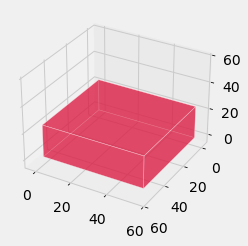

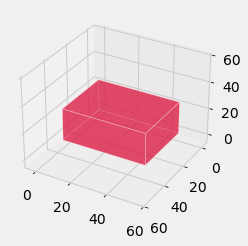

In [14]:
vis_box(np.array([boxes[0]]), np.array([[0,0,0]]))
vis_box(np.array([boxes[-1]]), np.array([[0,0,0]]))

In [15]:
def raw_to_input(container, s_order, r_boxes, num_max_remain, env_l=20, env_b=20, env_h=20): # K, 
    # input (L, B), (N, k, 3), (N, num_max_remain, 3)
    # return (N, L*B), (N, k, 3), (N, num_max_remain, 3), N은 조합*순열 수
    #  s_order = np.array(s_order)/20, 
    container = np.array([container]*len(s_order)).reshape((-1, env_l,env_b,1))
    r_boxes = np.array([padding_boxes(get_remain(s_boxes, r_boxes), num_max_remain) for s_boxes in s_order]) #(N, num_max_remain, 3)
    # s_order = np.array([padding_boxes(s_boxes, K) for s_boxes in s_order])
    # s_order = s_order.astype('int')
    container,r_boxes = np.array(container)/env_h, np.array(r_boxes)/env_l #scaline
    container = container.astype(np.float32)
    r_boxes = r_boxes.astype(np.float32)
    return container, r_boxes #s_order, 

In [16]:
def get_selected_location(s_order, pred_pos_org, used_boxes_org, state_org,
                         bboxes, big):
    # 정해진 순서에 따라 하나씩 적재
    s_locs, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c  = [],[],[],[],[]
    next_cube_c = []
    for boxes in s_order:
        env = Bpp3DEnv_RealData(length=397,breadth=229,height=110,
                       bboxes=bboxes,bboxes_h=big)
        state = state_org.copy()
        next_state = np.zeros((397,229))
        env.convert_state(state)
        pred_pos = pred_pos_org.copy()
        used_boxes = used_boxes_org.copy()
        num_loaded_box = 0
        s_loc = np.zeros((397,229,110))
        for box in boxes:
            if np.sum(box)==0:
                f_upleft = []
            else:
                f_upleft = get_f_upleft(box, env)
            if len(f_upleft) == 0:
                continue
            xyz = get_locxyz(f_upleft, env.container_h) #높이 반환
            fixted_xyz = fixed_pos(xyz) # 가능한 적재 위치 중 하나 선택
            xy = fixted_xyz[:2].astype('int')
            next_state = env.step(xy,box[0],box[1],box[2]).copy()########################
            num_loaded_box += 1
            pred_pos.append(fixted_xyz)
            used_boxes.append(box)
            # location
            x,y,z = fixted_xyz.astype('int')
            l,b,h = box
            s_loc[x:x+l, y:y+b, z:z+h] = 1
            
        s_locs.append(s_loc)
        pred_pos_c.append(pred_pos)
        used_boxes_c.append(used_boxes)
        #next_state_c.append(next_state) #############################
        next_state_h = env.update_h().copy()
        next_state_c.append(next_state_h)
        next_cube = env.container.copy()
        next_cube_c.append(next_cube)
        num_loaded_box_c.append(num_loaded_box)
        
    s_locs = np.stack(s_locs) #(N, 20,20,20)
    # fig = plt.figure()
    # ax = fig.gca(projection='3d')
    # ax.set_aspect('auto')
    # ax.voxels(s_locs[1], edgecolor="k")
    # plt.show()
    return s_locs, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c, next_cube_c

In [18]:
for episode in range(max_episode):
    st = time.time()
    env.reset()
    done = False
    step = 0
    
    history, used_boxes, remains, comb, pred_pos, actions, s_orders = [],[],[],[],[],[],[]
    next_history, next_comb, next_remains, next_s_orders = [],[],[],[]
    
    boxes_all = np.array(boxes).copy()
    r_boxes = boxes_all.copy()
    
    while not done:
        state = env.container.copy()
        k = min(K, len(r_boxes))
        step += 1
        
        selected = cbn_select_boxes(r_boxes[:n_candidates],k)
        s_order = get_selected_order(selected, k)

        state_h = env.update_h().copy()
        #print(np.sum(state_h))
        in_state, in_r_boxes = raw_to_input(state_h,s_order,r_boxes,num_max_remain,
                                           397,229,110)
        
        s_loc_c, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c, next_cube_c = get_selected_location(s_order, pred_pos, used_boxes, state, bboxes, big)
        loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                     env.height) for s_loc in s_loc_c])
        
        action_idx = agent.get_action(in_state, loaded_mh_c, in_r_boxes)
        
        history.append(in_state[action_idx])
        s_loc = s_loc_c[action_idx]
        loaded_mh = get_loaded_mh(s_loc, env.length, env.breadth, env.height)
        comb.append(loaded_mh)
        
        actions.append(action_idx)
        remains.append(in_r_boxes[action_idx])
        env.convert_state(next_cube_c[action_idx])
        
        next_state = env.container.copy()
        next_state_h = env.container_h.copy()
        next_history.append(next_state_h)
        
        num_loaded_box = num_loaded_box_c[action_idx]
        if num_loaded_box != 0:
            new_used_boxes = get_remain(used_boxes, used_boxes_c[action_idx])
            r_boxes = get_remain(new_used_boxes, r_boxes)
        else:
            r_boxes = get_remain(s_order[action_idx], r_boxes)
            
        used_boxes = used_boxes_c[action_idx]
        pred_pos = pred_pos_c[action_idx]
        
        if len(r_boxes) == 0:
            done = True
            next_remains.append(np.zeros((num_max_remain, 3)))
            next_comb.append(np.zeros((1,397,229,2)))
            next_s_orders.append(np.zeros((1,1,3)))
        else:
            next_remains.append(r_boxes)
            k = min(K, len(r_boxes))
            selected = cbn_select_boxes(r_boxes[:n_candidates], k)
            s_order = get_selected_order(selected, k)
            s_loc_c, _,_,_,_,_ = get_selected_location(s_order, pred_pos,
                                                      used_boxes, next_state,
                                                      bboxes, big)
            loaded_mh_c = np.array([get_loaded_mh(s_loc, env.length, env.breadth,
                                                 env.height) for s_loc in s_loc_c])
            next_comb.append(loaded_mh_c)
            next_s_orders.append(s_order)
            
            if np.sum(env.container_h != env.height) == 0:
                done = True
        print(1-(len(r_boxes)/len(boxes)))
        if done:
            terminal_reward = len(r_boxes)/len(boxes)
            tr_l.append(terminal_reward)
            
            is_last = False
            N = len(history)
            for i in range(N):
                if i == N-1:
                    is_last = True
                reward = (agent.gamma ** (N-i-1)) * terminal_reward
                in_next_history, in_next_remains = raw_to_input(next_history[i],
                                                               next_s_orders[i],
                                                               next_remains[i],
                                                               num_max_remain,
                                                               397,229,110)
                agent.append_sample(history[i], comb[i], remains[i], actions[i],
                                   reward, is_last, in_next_history,
                                   next_comb[i], in_next_remains)
            agent.train()
            avg_actor_loss.append(agent.avg_actor_loss / float(step))
            avg_critic_loss.append(agent.avg_critic_loss / float(step))
            used_box_list.append(used_boxes)
            pred_pos_list.append(pred_pos)
    log = "=====episode: {:5d} | ".format(episode)
    log += "memory length: {:5d} | ".format(len(agent.memory))
    log += "env.terminal_reward(): {:.3f} | ".format(env.terminal_reward())
    log += "avg actor loss : {:6f} ".format(agent.avg_actor_loss / float(step))
    log += "avg critic loss : {:6f} ".format(agent.avg_critic_loss / float(step))
    log += "time: {:.3f}".format(time.time()-st)
    print(log)
    
    agent.avg_actor_loss = 0
    agent.avg_critic_loss = 0
    agent.memory.clear()

0.09375
0.125
0.21875
0.3125
0.40625
0.5
0.59375
0.6875
0.78125
0.875
0.96875
1.0
=====episode:     0 | memory length:    12 | env.terminal_reward(): 1.729 | avg actor loss : 7849.718099 avg critic loss : 171.738363 time: 110.360
0.09375
0.125
0.21875
0.3125
0.40625
0.5
0.59375
0.6875
0.78125
0.875
0.96875
1.0
=====episode:     1 | memory length:    12 | env.terminal_reward(): 1.729 | avg actor loss : 55.174271 avg critic loss : 6.671960 time: 134.879
0.09375
0.125
0.21875
0.3125
0.40625
0.5
0.59375
0.6875
0.78125
0.875
0.96875
1.0


ResourceExhaustedError: OOM when allocating tensor with shape[12,395,227,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:MaxPoolGrad]